In [182]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkbar
import time
import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

In [3]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

In [4]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    
        
    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1   
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [65]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [341]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        
        if data is not None:
            self.leaf = data
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
            self.leaf.requires_grad = True
        
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        return torch.cat(states, dim=0)
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        if self.k == 1:
            return
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [451]:
def initialize_H(k, P, R, s, a, gamma=0.9):
    h = torch.empty([s * a] * k, dtype=torch.float32)
    
    pbar = pkbar.Pbar(name='initialize H, k='+str(k), target=(s * a))
    for i in range(s * a):
        pbar.update(i)
        in_edge = torch.sum(P[..., i // a])

        if k == 1:
            J = R[i // a, i % a] * in_edge
            h[i] = gamma ** k * J

        if k == 2:
            for j in range(s * a):
                J = P[i // a, i % a, j // a] * R[j // a, j % a] * in_edge
                h[i, j] = gamma ** k * J

        if k == 3:
            for j in range(s * a):
                for l in range(s * a):
                    J = P[i // a, i % a, j // a] * \
                        P[j // a, j % a, l // a] * \
                        R[l // a, l % a] * \
                        in_edge
                    h[i, j, l] = gamma ** k * J

    return tn.Node(h, backend=backend)

In [630]:
def build_root(H, chi=10):
    
    rank = H.get_rank()
    if rank == 1:
        return [H]
    
    l_edges, r_edges = [], []
    for r in range(rank // 2):
        l_edges.append(H[r])
    for r in range(rank // 2, H.get_rank()):
        r_edges.append(H[r])
        
    l_tree, root, r_tree, _ = tn.split_node_full_svd(H, l_edges, r_edges, chi)
    return [root, l_tree, r_tree]

In [642]:
k = 3
s, a = 25, 4
lr = 0.00001

data = torch.randn((s * a, 1), requires_grad=True)
H = []
H_core = []
for i in range(k):
    H.append(initialize_H(i + 1, P, R, s, a, gamma=0.95))
    this_core = build_root(H[i])
    H_core.append(this_core)

initialize H, k=1
100/100  [==============================] - 0.1s
initialize H, k=2
100/100  [==============================] - 0.4s
initialize H, k=3
100/100  [==============================] - 30.6s


In [643]:
energy_history = []
epochs = int(2e4)
Pbar = pkbar.Pbar(name='progress', target=epochs)

op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)
for e in range(epochs):
    spins = []
    core = []
    edge = []
    energy = 0
    op.zero_grad()
    
    for i in range(k):
        core.append(tn.replicate_nodes(H_core[i]))
        edge.append([])
        for j in range(len(core[i])):
            edge[i] += core[i][j].get_all_dangling()
    
    for i in range(k):
        spins.append(K_Spin(s, a, i + 1, data=data))
        for j in range(i + 1):
            edge[i][j] ^ spins[i].qubits[j][0]
            
    for i in range(k):
        energy -= contractors.branch(tn.reachable(core[i]), nbranch=1).get_tensor()
    energy.backward()
    energy_history.append(energy)
    
    op.step()
    Pbar.update(e)

progress
20000/20000  [==============================] - 343.3s


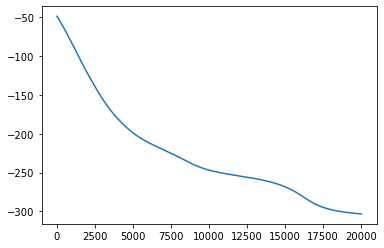

In [644]:
# with plt.style.context(['science', 'notebook']):
plt.plot(energy_history[:])
plt.title='Policy Iteration using K-Spin Hamiltonian'
plt.xlabel='Number of iterations'
plt.ylabel='Energy'

plt.show()

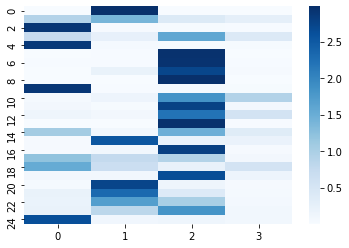

In [645]:
result = np.zeros((s, a))
for i in range(k):
    result += spins[i].data.reshape(s, a).detach().numpy()
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [646]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])

In [647]:
policy.reshape(5, 5)

tensor([[1., 1., 0., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 2.],
        [1., 2., 0., 0., 2.],
        [1., 1., 1., 2., 0.]])

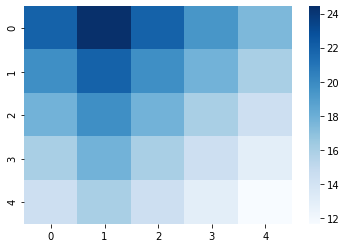

In [626]:
sns.heatmap(target, cmap='Blues')